# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [10]:
#train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [5]:
train_dataset_path='D:/DatasetMedicalWasteCroppedBalancedOversamplingCopying/'

## Testing Set DIR

In [2]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [3]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 12274 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15342 files belonging to 41 classes.
Using 3068 files for validation.


In [8]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [9]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [10]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


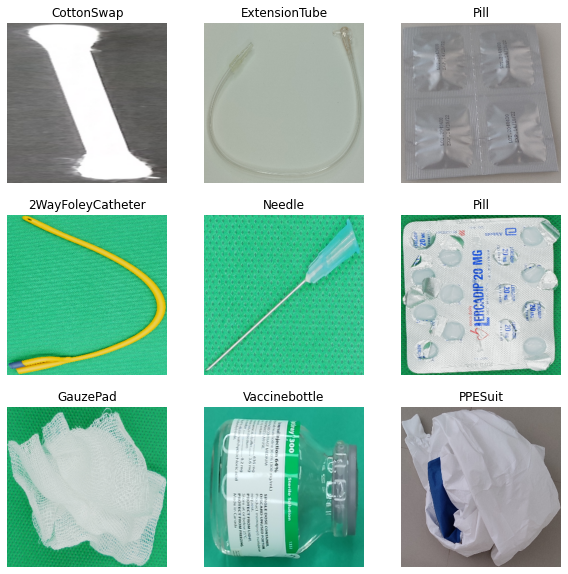

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [15]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [24]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/'

In [30]:
EPOCHS = 2000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-Oversampling-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/2000
192/192 [==============================] - 152s 303ms/step - loss: 0.7949 - accuracy: 0.8475 - val_loss: 0.2072 - val_accuracy: 0.9716
Epoch 2/2000
192/192 [==============================] - 35s 181ms/step - loss: 0.1404 - accuracy: 0.9822 - val_loss: 0.1036 - val_accuracy: 0.9876
Epoch 3/2000
192/192 [==============================] - 35s 181ms/step - loss: 0.0753 - accuracy: 0.9927 - val_loss: 0.0699 - val_accuracy: 0.9909
Epoch 4/2000
192/192 [==============================] - 35s 180ms/step - loss: 0.0488 - accuracy: 0.9967 - val_loss: 0.0513 - val_accuracy: 0.9941
Epoch 5/2000
192/192 [==============================] - 35s 181ms/step - loss: 0.0347 - accuracy: 0.9979 - val_loss: 0.0391 - val_accuracy: 0.9951
Epoch 6/2000
192/192 [==============================] - 35s 181ms/step - loss: 0.0261 - accuracy: 0.9985 - val_loss: 0.0307 - val_accuracy: 0.9980
Epoch 7/2000
192/192 [==============================] - 35s 181ms/step - loss: 0.0204 - accuracy: 0.9992 - val_loss: 

Text(0.5, 1.0, 'Training and Validation Accuracy')

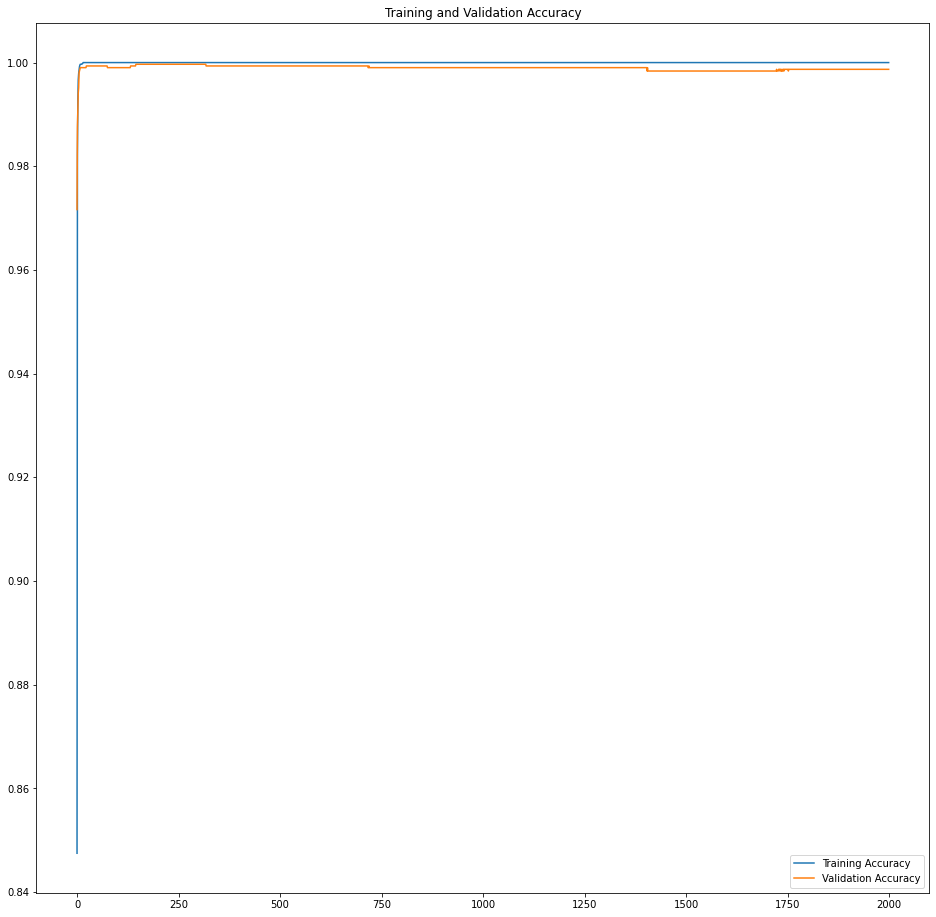

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


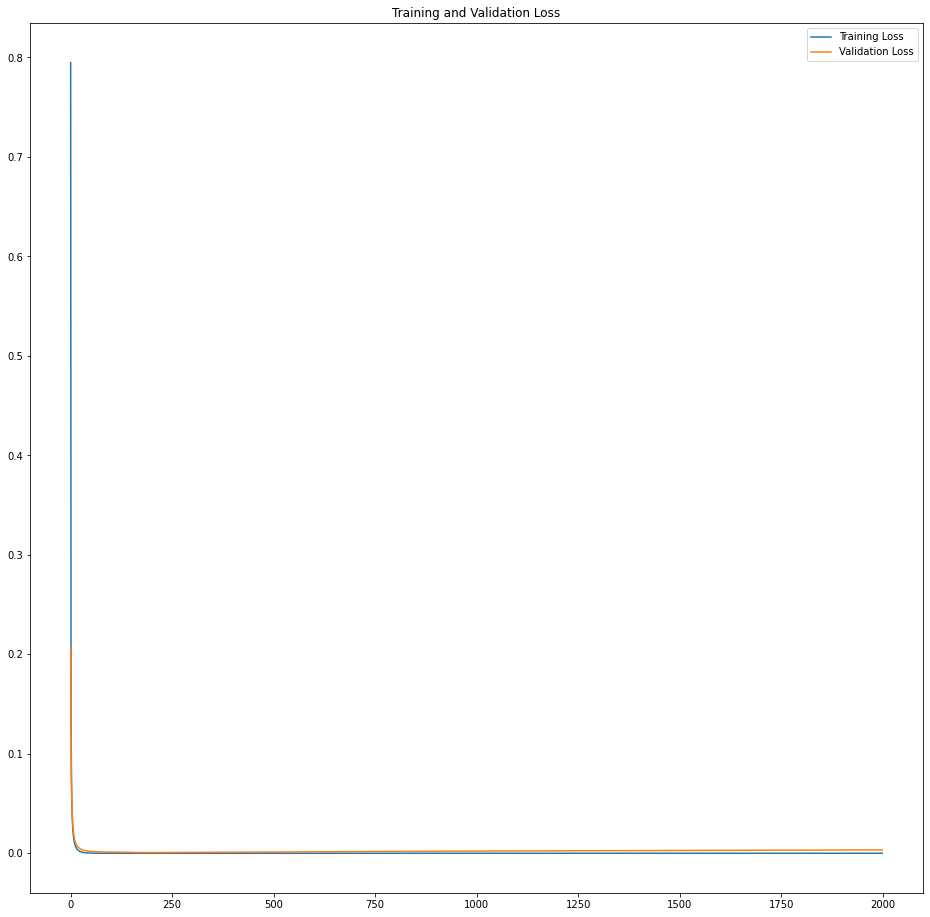

In [32]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 355ms/step - loss: 0.7810 - accuracy: 0.8434
test_indoor_ds_results:test loss, test acc: [0.7809759974479675, 0.843366801738739]


In [34]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 442ms/step - loss: 2.1662 - accuracy: 0.7277
test_outdoor_ds_results:test loss, test acc: [2.16615629196167, 0.727707028388977]


In [35]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 202ms/step - loss: 2.0167 - accuracy: 0.7094
test_belt_ds_results:test loss, test acc: [2.016730785369873, 0.7094288468360901]


In [22]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/OurOutputLayer-Oversampling-NoAug-epoch0040-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/OurOutputLayer-Oversampling-NoAug-epoch0080-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/OurOutputLayer-Oversampling-NoAug-epoch0120-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/OurOutputLayer-Oversampling-NoAug-epoch0160-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/OurOutputLayer-Oversampling-NoAug-epoch0200-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-Oversampling-NoAug-NormalLR/OurOutputLayer-Oversampling-NoAug-epoch0240-val_acc1.00.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_Freez

# Testing in testset

In [25]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 146ms/step - loss: 1.4709 - accuracy: 0.7076
Epoch040 
 test_indoor_acc=0.865105926990509 
 test_outdoor_acc=0.7531847357749939 
 test_belt_acc=0.7076156139373779
35/35 [==============================] - 5s 145ms/step - loss: 1.8918 - accuracy: 0.7017
Epoch080 
 test_indoor_acc=0.8656633496284485 
 test_outdoor_acc=0.7544586062431335 
 test_belt_acc=0.7017225623130798
35/35 [==============================] - 5s 146ms/step - loss: 2.2272 - accuracy: 0.7053
Epoch120 
 test_indoor_acc=0.8639910817146301 
 test_outdoor_acc=0.7503184676170349 
 test_belt_acc=0.7053490281105042
35/35 [==============================] - 5s 145ms/step - loss: 2.3323 - accuracy: 0.7117
Epoch160 
 test_indoor_acc=0.8617614507675171 
 test_outdoor_acc=0.7439490556716919 
 test_belt_acc=0.7116953730583191
35/35 [==============================] - 5s 149ms/step - loss: 2.3580 - accuracy: 0.7090
Epoch200 
 test_indoor_acc=0.8612040281295776 
 test_outdoor_acc=0.7401273846626

In [26]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(40, 2040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

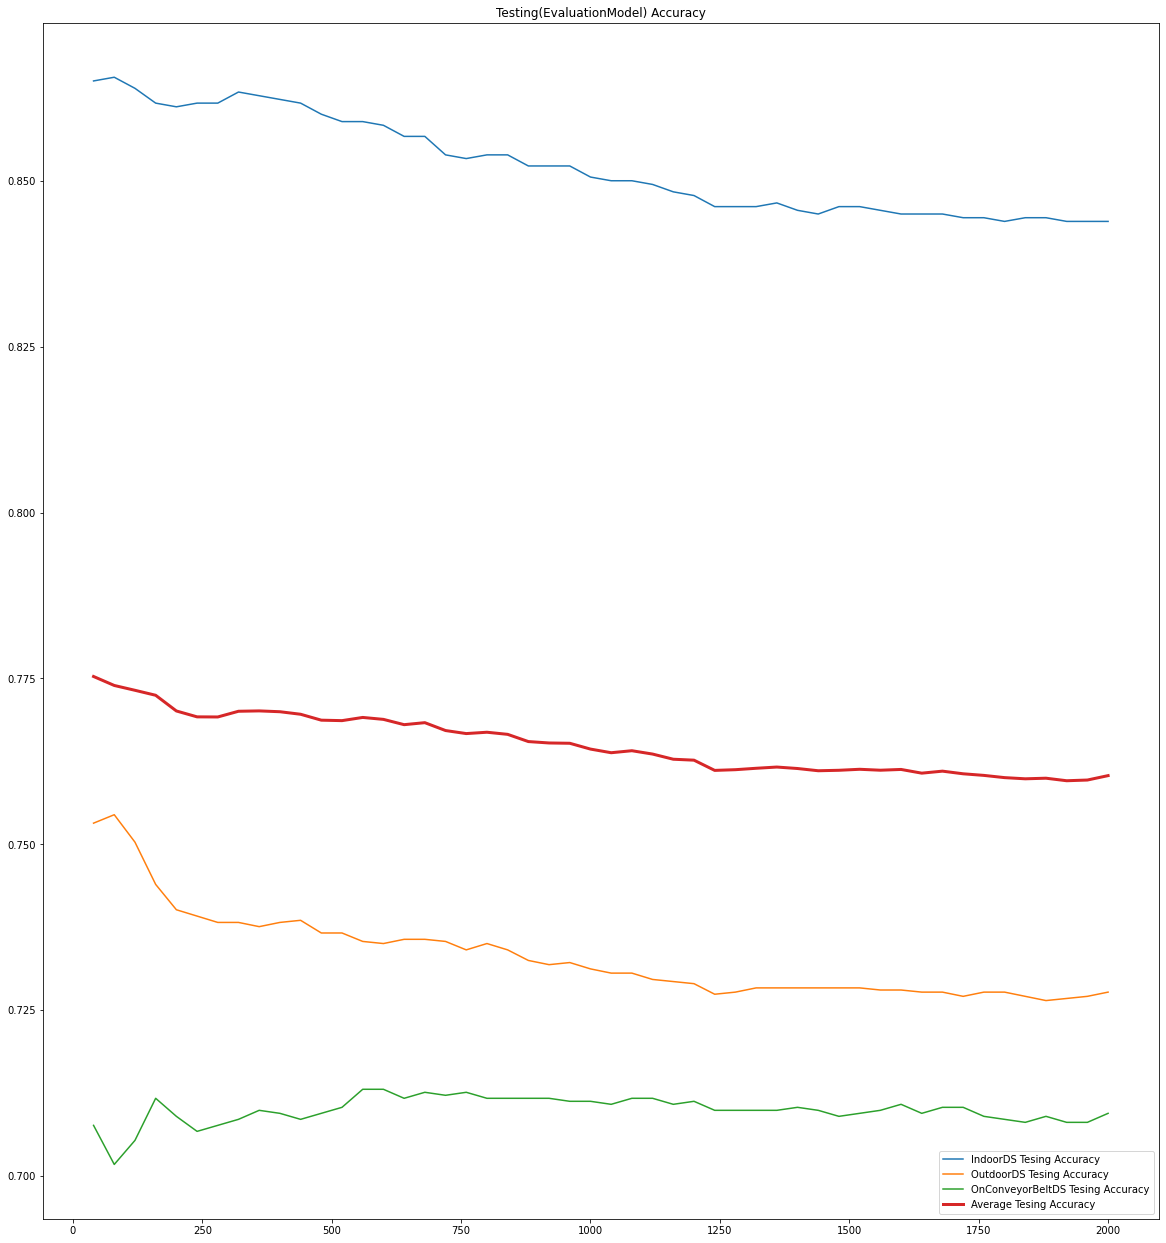

In [27]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [28]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7753020922342936
max index -> 0
The [Epoch] of max acc -> 40


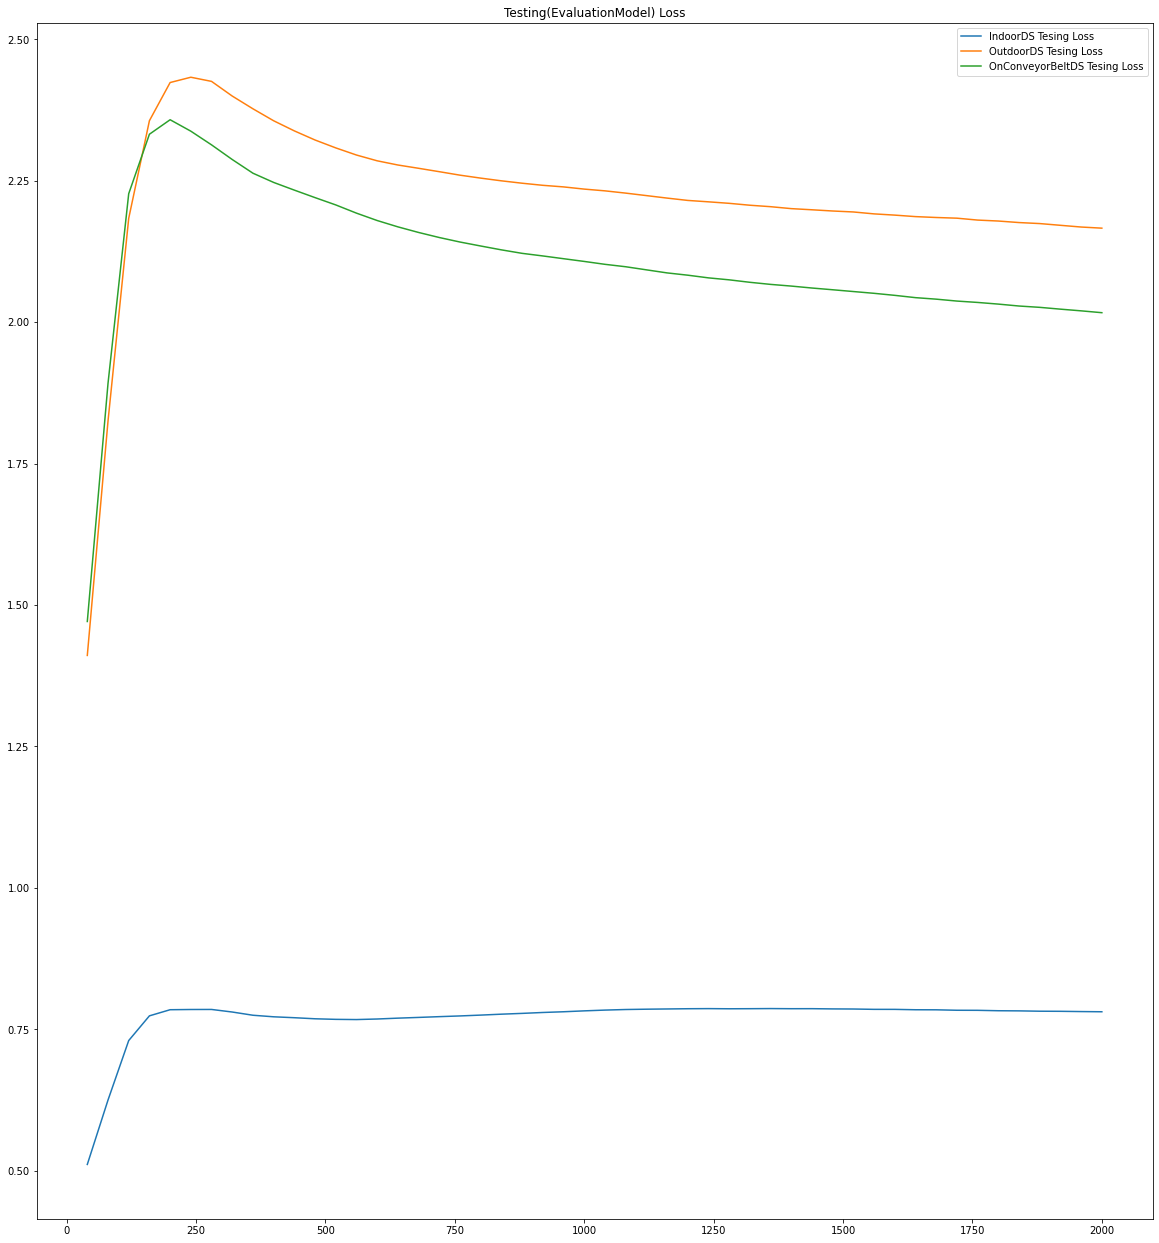

In [41]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [42]:
test_indoor_acc

[0.865105926990509,
 0.8656633496284485,
 0.8639910817146301,
 0.8617614507675171,
 0.8612040281295776,
 0.8617614507675171,
 0.8617614507675171,
 0.8634336590766907,
 0.8628762364387512,
 0.8623188138008118,
 0.8617614507675171,
 0.8600891828536987,
 0.8589743375778198,
 0.8589743375778198,
 0.8584169745445251,
 0.8567447066307068,
 0.8567447066307068,
 0.8539576530456543,
 0.8534002304077148,
 0.8539576530456543,
 0.8534002304077148,
 0.8522853851318359,
 0.8522853851318359,
 0.8522853851318359,
 0.8506131768226624,
 0.8506131768226624,
 0.8500557541847229,
 0.8500557541847229,
 0.8483834862709045,
 0.8483834862709045,
 0.8461538553237915,
 0.8461538553237915,
 0.8461538553237915,
 0.846711277961731,
 0.845596432685852,
 0.8450390100479126,
 0.8461538553237915,
 0.845596432685852,
 0.845596432685852,
 0.8450390100479126,
 0.8450390100479126,
 0.8450390100479126,
 0.8444815874099731,
 0.8444815874099731,
 0.8439241647720337,
 0.8444815874099731,
 0.8450390100479126,
 0.843924164772033

In [43]:
test_outdoor_acc

[0.7531847357749939,
 0.7544586062431335,
 0.7503184676170349,
 0.7439490556716919,
 0.7401273846626282,
 0.7394904494285583,
 0.7382165789604187,
 0.7382165789604187,
 0.7375796437263489,
 0.7382165789604187,
 0.7382165789604187,
 0.737261176109314,
 0.7366241812705994,
 0.7350318431854248,
 0.7350318431854248,
 0.7353503108024597,
 0.7356687784194946,
 0.7353503108024597,
 0.7340764403343201,
 0.7350318431854248,
 0.7340764403343201,
 0.7324841022491455,
 0.7318471074104309,
 0.7321656346321106,
 0.7312101721763611,
 0.7305732369422913,
 0.7305732369422913,
 0.7296178340911865,
 0.7292993664741516,
 0.7289808988571167,
 0.7273885607719421,
 0.727707028388977,
 0.7283439636230469,
 0.7283439636230469,
 0.7283439636230469,
 0.7283439636230469,
 0.7283439636230469,
 0.7283439636230469,
 0.728025496006012,
 0.728025496006012,
 0.7273885607719421,
 0.727707028388977,
 0.7270700931549072,
 0.7273885607719421,
 0.7273885607719421,
 0.7267515659332275,
 0.7264330983161926,
 0.726751565933227

In [44]:
test_belt_acc

[0.7080689072608948,
 0.7017225623130798,
 0.7053490281105042,
 0.7116953730583191,
 0.7089754939079285,
 0.7067089676856995,
 0.7076156139373779,
 0.7085222005844116,
 0.7098821401596069,
 0.7094288468360901,
 0.7085222005844116,
 0.7094288468360901,
 0.7103354334831238,
 0.7130553126335144,
 0.7130553126335144,
 0.7116953730583191,
 0.7121486663818359,
 0.7121486663818359,
 0.7126020193099976,
 0.7116953730583191,
 0.7116953730583191,
 0.7116953730583191,
 0.7116953730583191,
 0.7112420797348022,
 0.7112420797348022,
 0.7107887864112854,
 0.7121486663818359,
 0.7116953730583191,
 0.7107887864112854,
 0.7112420797348022,
 0.7098821401596069,
 0.7098821401596069,
 0.7103354334831238,
 0.7098821401596069,
 0.7103354334831238,
 0.7098821401596069,
 0.7089754939079285,
 0.7094288468360901,
 0.7098821401596069,
 0.7107887864112854,
 0.7094288468360901,
 0.7103354334831238,
 0.7103354334831238,
 0.7094288468360901,
 0.7085222005844116,
 0.7080689072608948,
 0.7089754939079285,
 0.7076156139

In [45]:
test_indoor_loss

[0.5110929608345032,
 0.6249105930328369,
 0.7300803065299988,
 0.7737541794776917,
 0.7845903038978577,
 0.7849860787391663,
 0.7850731611251831,
 0.7805262804031372,
 0.7748240232467651,
 0.77208012342453,
 0.7704616785049438,
 0.7685747146606445,
 0.7675626277923584,
 0.7671949863433838,
 0.7681800127029419,
 0.7696969509124756,
 0.7709831595420837,
 0.7723416090011597,
 0.7736039161682129,
 0.7750816345214844,
 0.7767146825790405,
 0.7781134843826294,
 0.7797092795372009,
 0.7809872031211853,
 0.7825749516487122,
 0.7839311957359314,
 0.7849521636962891,
 0.7855117321014404,
 0.7859178781509399,
 0.7863427996635437,
 0.7865445017814636,
 0.7862617373466492,
 0.7864032983779907,
 0.7866326570510864,
 0.7863796353340149,
 0.7864395380020142,
 0.7860209345817566,
 0.7858366370201111,
 0.785245954990387,
 0.785209596157074,
 0.7845408916473389,
 0.7844361662864685,
 0.7836430072784424,
 0.7835362553596497,
 0.7828013300895691,
 0.7825584411621094,
 0.7819467782974243,
 0.78178668022155

In [46]:
test_outdoor_loss

[1.4108740091323853,
 1.825082540512085,
 2.183480739593506,
 2.356106996536255,
 2.423574924468994,
 2.43293833732605,
 2.4256229400634766,
 2.3996763229370117,
 2.3771448135375977,
 2.3559930324554443,
 2.3380930423736572,
 2.3219783306121826,
 2.3080413341522217,
 2.295429229736328,
 2.285217046737671,
 2.277796745300293,
 2.2719779014587402,
 2.265976667404175,
 2.259838819503784,
 2.2546133995056152,
 2.249828577041626,
 2.2456068992614746,
 2.2418954372406006,
 2.2390925884246826,
 2.2351982593536377,
 2.232112407684326,
 2.2281200885772705,
 2.2237260341644287,
 2.219306468963623,
 2.2151830196380615,
 2.2126994132995605,
 2.2100589275360107,
 2.206693172454834,
 2.204118251800537,
 2.2006754875183105,
 2.1986453533172607,
 2.196493625640869,
 2.1947829723358154,
 2.1913886070251465,
 2.189211845397949,
 2.186570167541504,
 2.1850087642669678,
 2.1837973594665527,
 2.1804492473602295,
 2.1787538528442383,
 2.1760547161102295,
 2.1742756366729736,
 2.171201229095459,
 2.168145656

In [47]:
test_belt_loss

[1.4708683490753174,
 1.8916943073272705,
 2.2270941734313965,
 2.332193613052368,
 2.3578083515167236,
 2.337599992752075,
 2.313408374786377,
 2.2874975204467773,
 2.2632884979248047,
 2.2470033168792725,
 2.2333877086639404,
 2.2201406955718994,
 2.207235813140869,
 2.1927027702331543,
 2.179654121398926,
 2.168468475341797,
 2.1585559844970703,
 2.1496105194091797,
 2.1416401863098145,
 2.134613037109375,
 2.1277952194213867,
 2.1216366291046143,
 2.117044687271118,
 2.1121666431427,
 2.1073427200317383,
 2.102236032485962,
 2.097963571548462,
 2.0924978256225586,
 2.0870707035064697,
 2.0830323696136475,
 2.078287363052368,
 2.074810028076172,
 2.07045841217041,
 2.066760301589966,
 2.0637733936309814,
 2.060333013534546,
 2.0572710037231445,
 2.054119348526001,
 2.0509729385375977,
 2.0473761558532715,
 2.0433192253112793,
 2.0406556129455566,
 2.037283182144165,
 2.03485107421875,
 2.031917095184326,
 2.028519630432129,
 2.0261833667755127,
 2.022979259490967,
 2.019993782043457

## Load Last Epoch and test in each class

In [29]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-Oversampling-NoAug-epoch0040-val_acc1.00.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
del x_test_indoor,x_test_outdoor,x_test_belt
del y_test_indoor,y_test_outdoor,y_test_belt
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5479
FP=1661
acc=0.7673669467787115
all check = 7140


In [6]:
print(TP_eachclass)

[89, 135, 107, 108, 111, 139, 66, 111, 134, 120, 84, 62, 43, 119, 70, 117, 238, 37, 158, 355, 66, 75, 239, 132, 117, 294, 687, 88, 112, 84, 102, 105, 85, 97, 96, 66, 247, 47, 81, 176, 80]


In [7]:
print(FP_eachclass)

[27, 12, 27, 9, 0, 21, 60, 55, 33, 23, 33, 51, 80, 43, 43, 59, 98, 75, 104, 30, 89, 38, 41, 1, 7, 134, 27, 41, 5, 47, 16, 22, 25, 16, 15, 66, 16, 62, 39, 37, 34]


In [8]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 91.83673469387756%
2WayFoleyCatheter acc = 79.8507462686567%
3WayConnectorforFoley acc = 92.3076923076923%
3Waystopcock acc = 100.0%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 52.38095238095239%
BootCover acc = 66.86746987951807%
CottonBall acc = 80.23952095808383%
CottonSwap acc = 83.91608391608392%
Dilator acc = 71.7948717948718%
DisposableInfusionSet acc = 54.86725663716814%
ExtensionTube acc = 34.959349593495936%
FaceShield acc = 73.4567901234568%
FrontLoadSyringe acc = 61.94690265486725%
GauzePad acc = 66.47727272727273%
Glove acc = 70.83333333333334%
GuideWire acc = 33.035714285714285%
LiquidBottle acc = 60.30534351145038%
Mask acc = 92.20779220779221%
NGTube acc = 42.58064516129032%
NasalCannula acc = 66.3716814159292%
Needle acc = 85.35714285714285%
OxygenMask acc = 99.24812030075188%
PPESuit acc = 94.35483870967742%
PharmaceuticalProduct acc = 68.69158878504673%
Pill acc = 96.21848739495799%
PillBottl

In [9]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   0,   0, ...,   0,   1,   0],
       [  0, 135,   0, ...,   0,   0,   0],
       [  0,   0, 107, ...,   0,   3,   7],
       ...,
       [  0,   0,   0, ...,  81,   1,   0],
       [  0,   0,   0, ...,   1, 176,   0],
       [  0,   1,   0, ...,   1,   1,  80]], dtype=int64)

In [10]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.        , 91.83673469,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 79.85074627, ...,  0.        ,
         2.23880597,  5.2238806 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 67.5       ,
         0.83333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        82.62910798,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.87719298,
         0.87719298, 70.1754386 ]])

<AxesSubplot:>

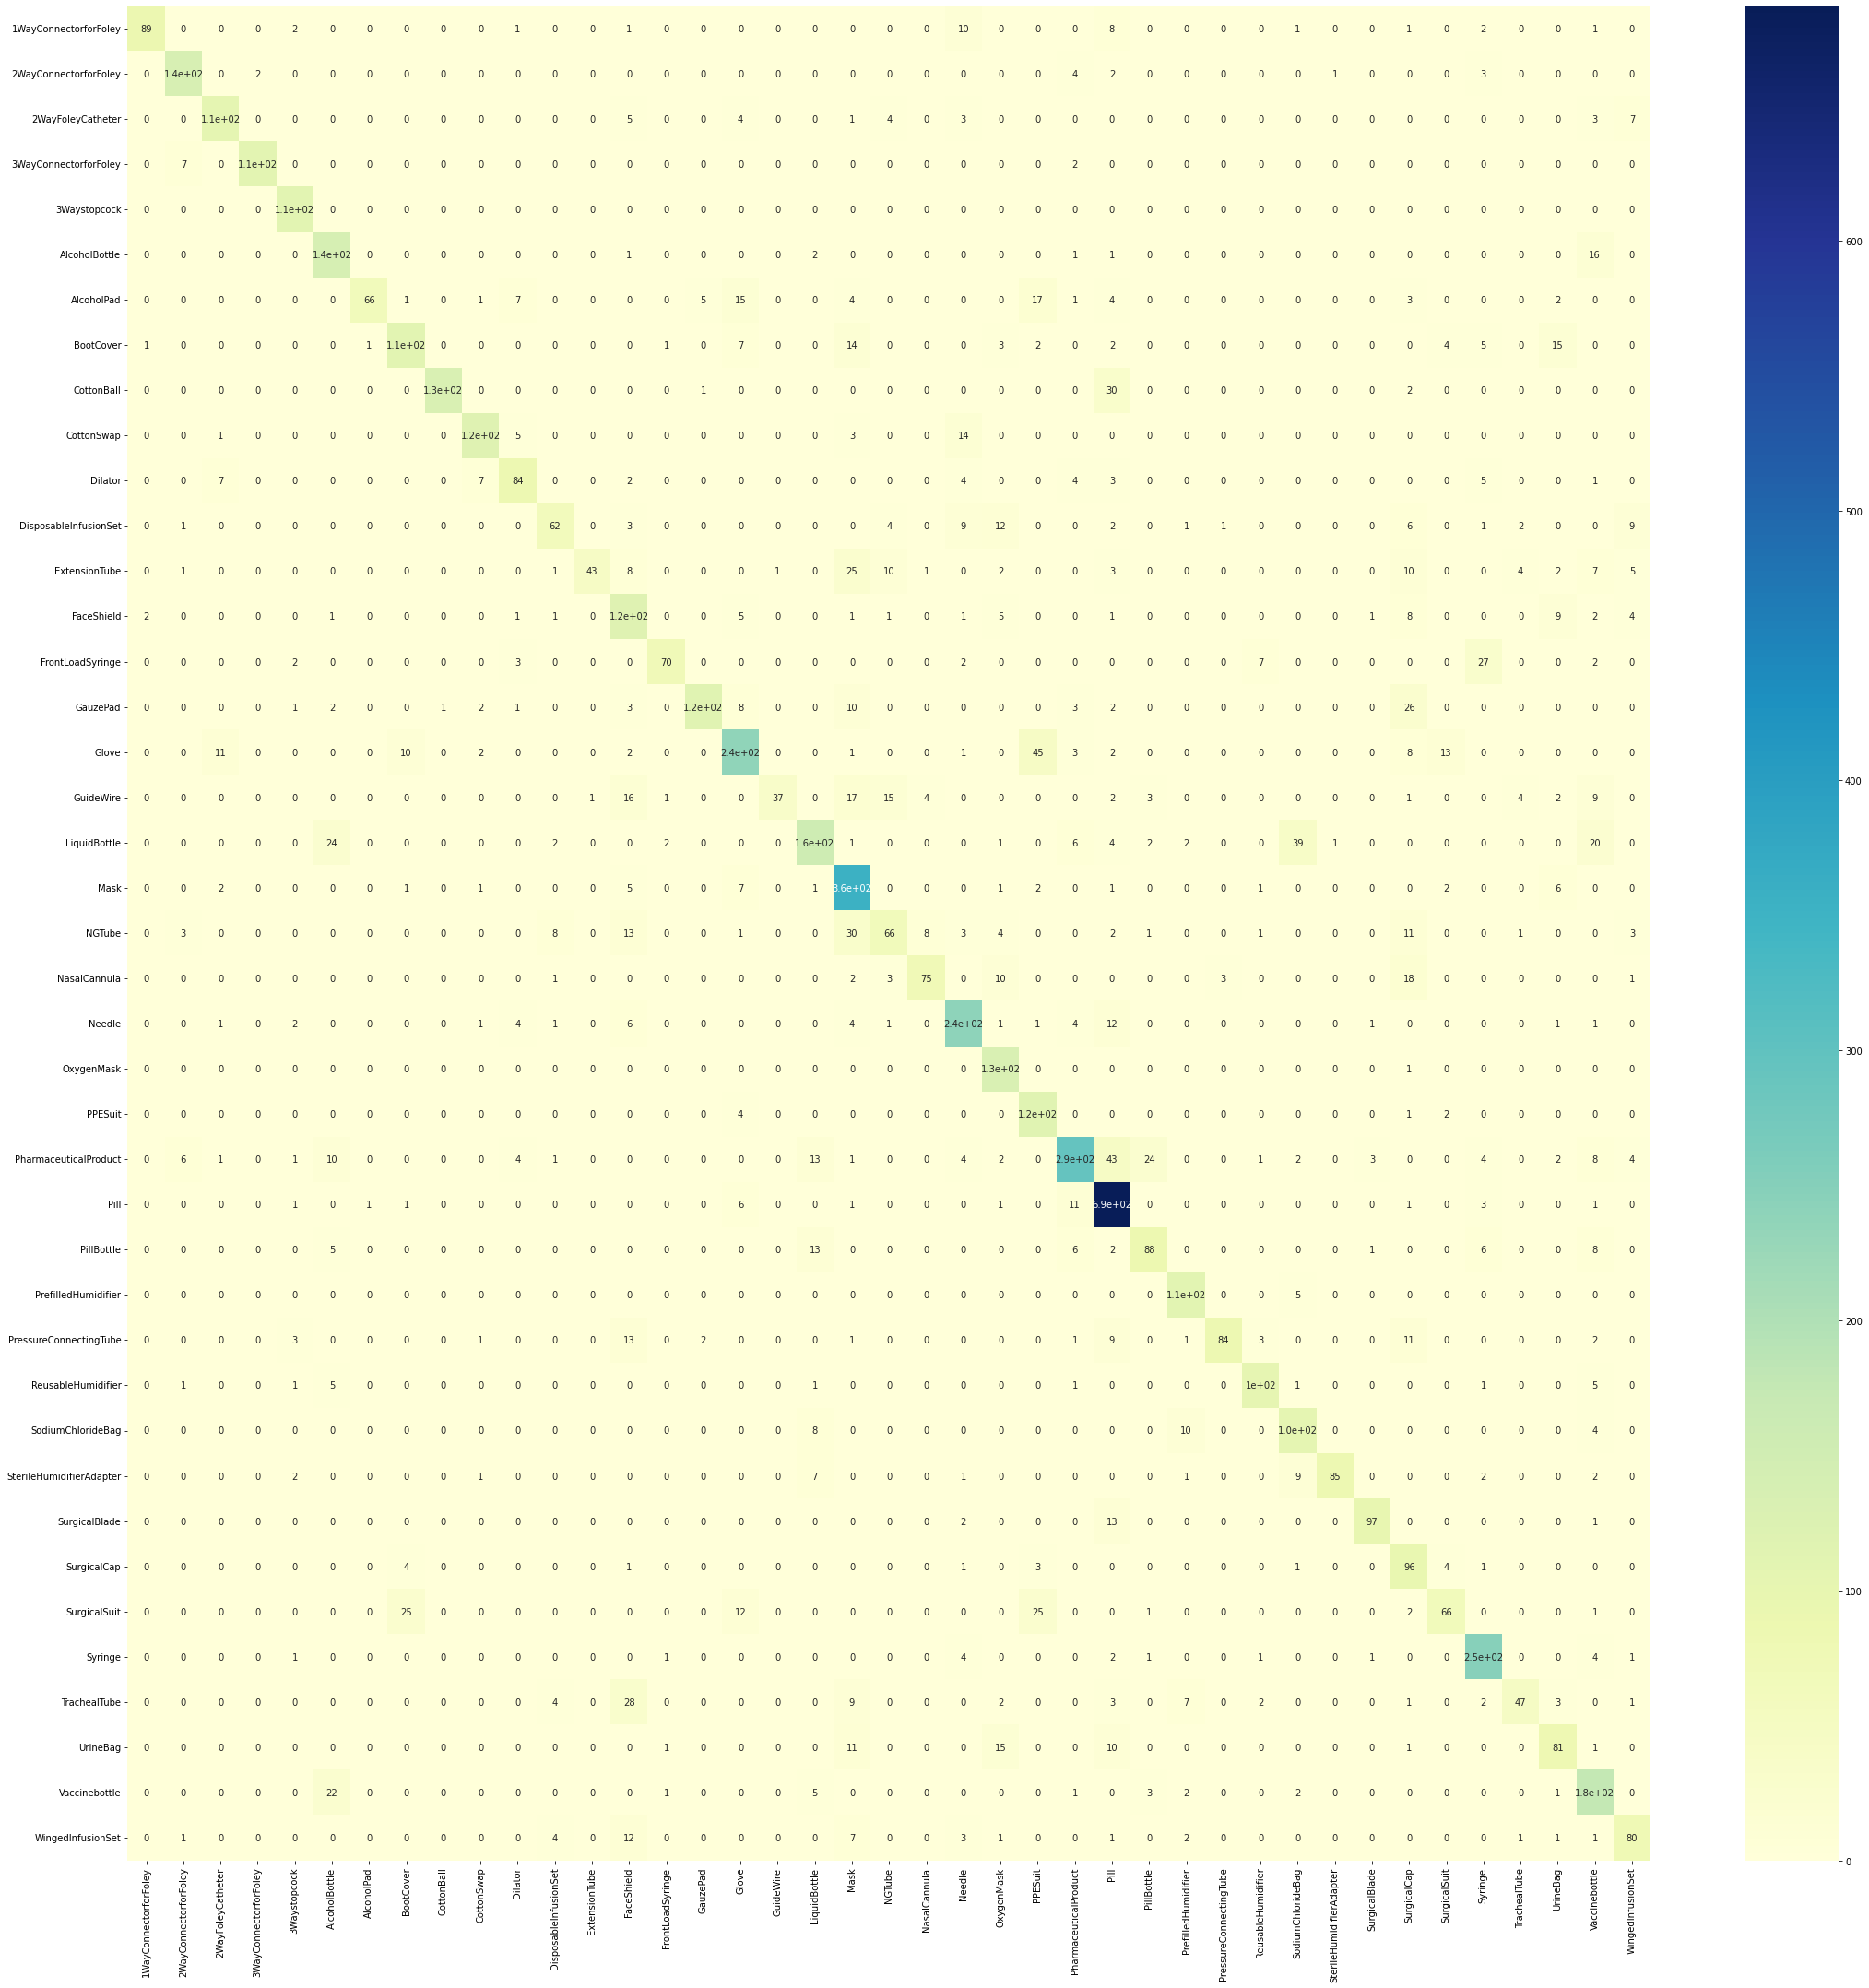

In [11]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

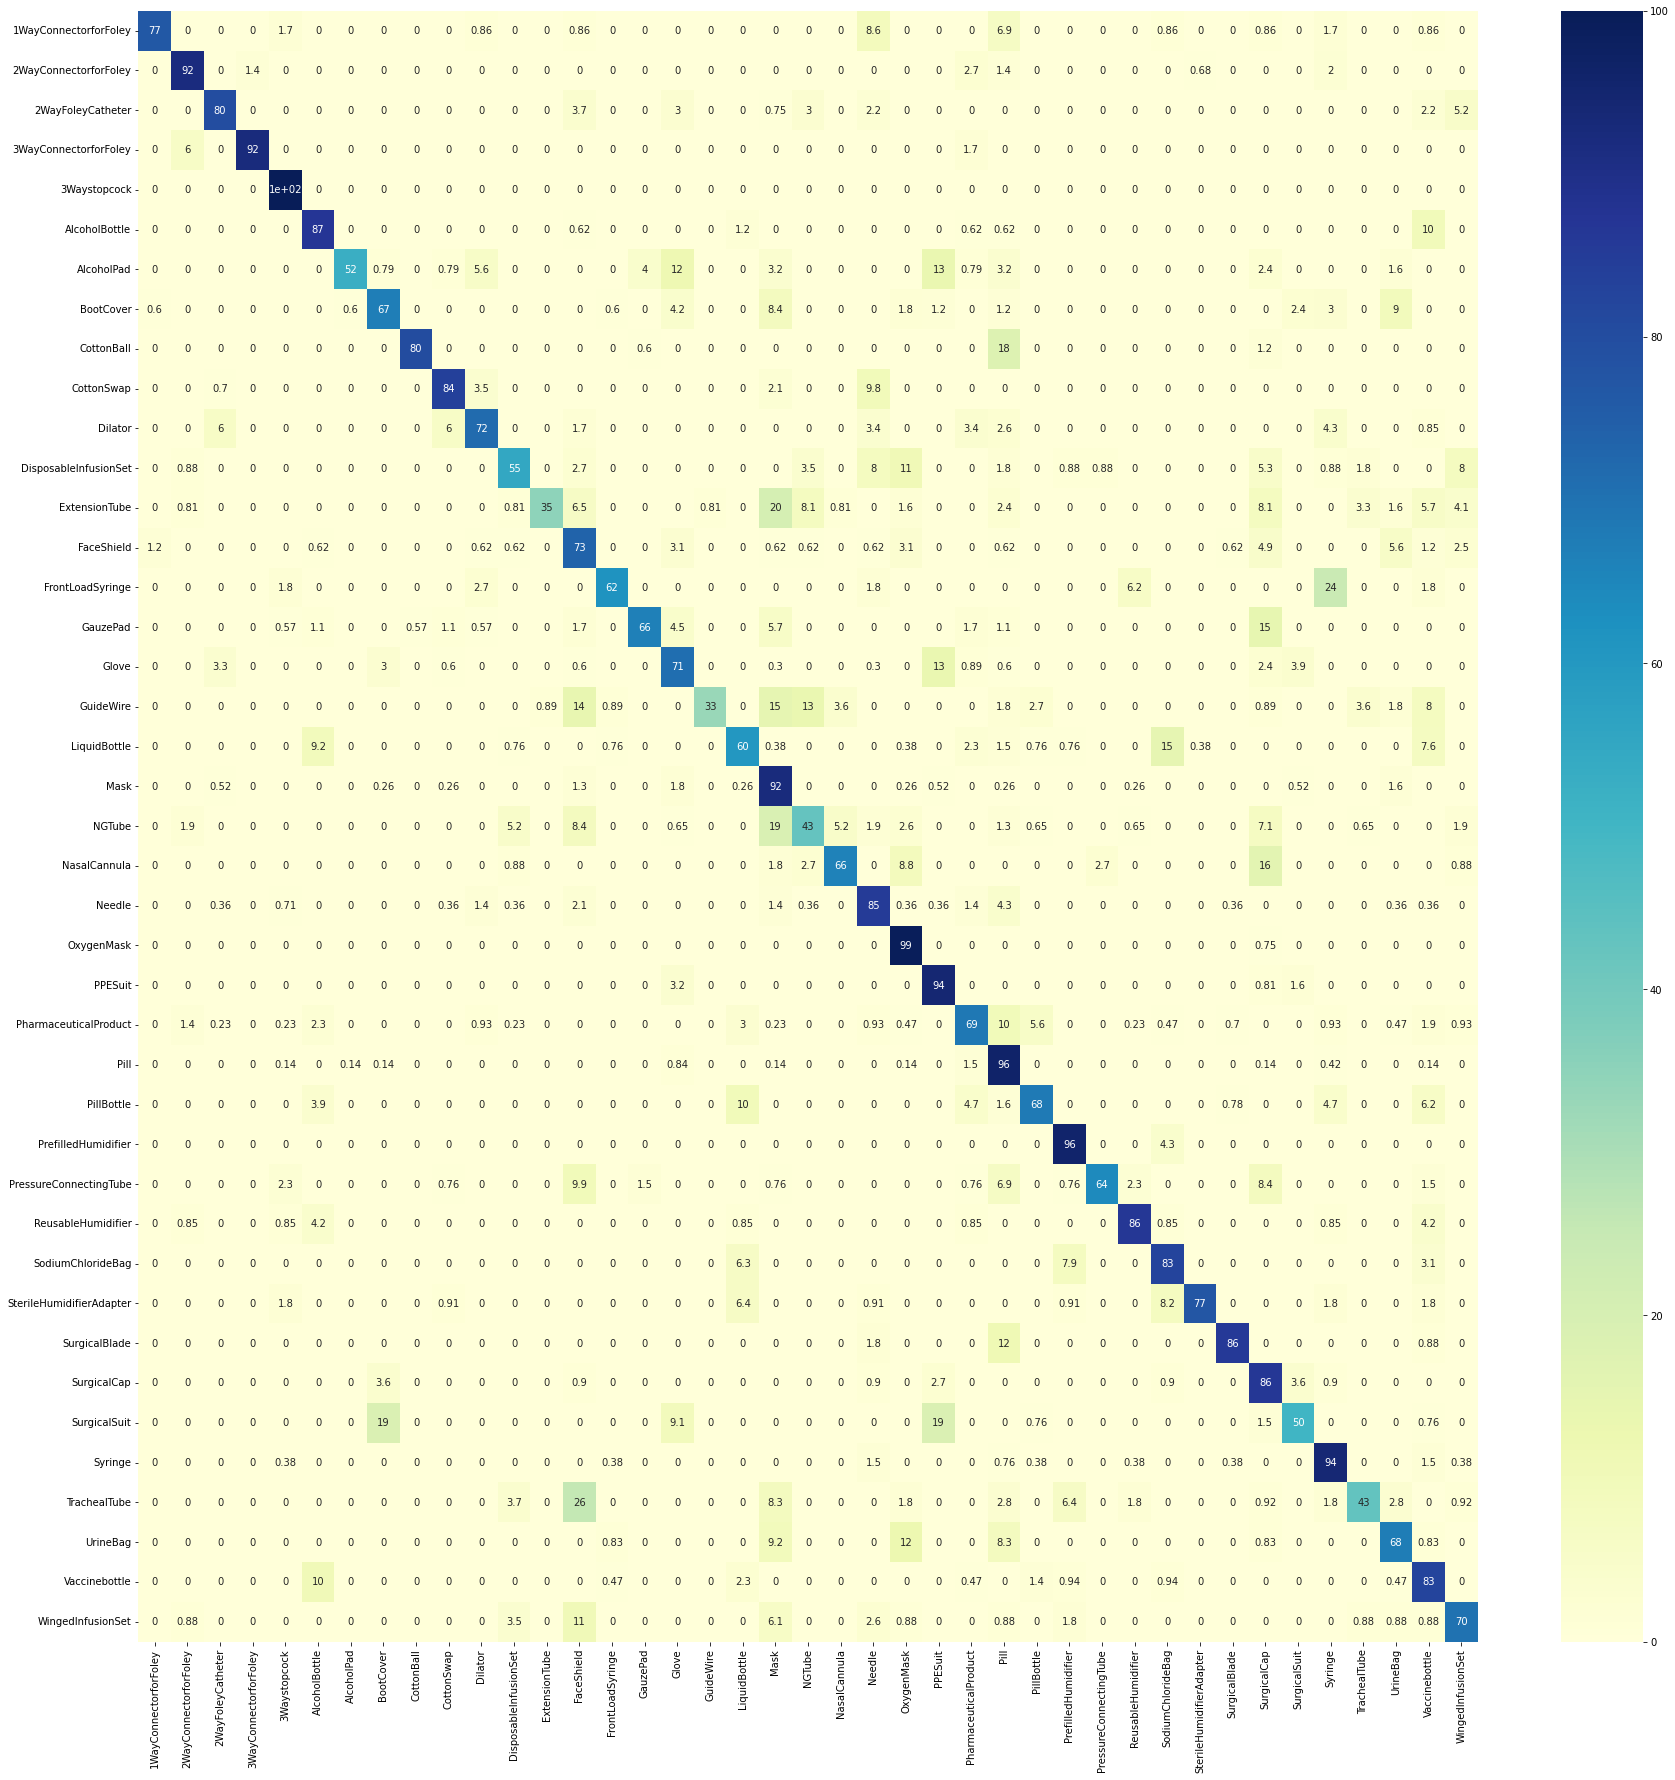

In [12]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")